In [1]:
suppressWarnings(suppressPackageStartupMessages({
    library(tidyverse)
    library(data.table)
}))


In [2]:
source('paths.sh')


In [3]:
trait_list_f %>%
fread() %>%
rename_with(
    function(x){str_replace(x, '#', '')}, starts_with("#")
) -> trait_list_df


In [4]:
fread(
    cmd = paste(
        sprintf(
            'find %s -name "*snpnetBETAs.tsv" -type f -print0',
            file.path(PRS202110_d, 'per_trait')
        ),
        'sort',
        'wc -l --files0-from=-',
        'tr " "  "\t"',
        sprintf('sed -e "s+%s++g"', file.path(PRS202110_d, 'per_trait')),
        sep=' | '
    ),
    head = F,
    col.names = c('wc_l', 'beta_f')
) %>%
filter(beta_f != 'total') %>%
mutate(
    GBE_ID = str_replace(str_replace(beta_f, '^/', ''), '.snpnetBETAs.tsv$', ''),
    n_variables = wc_l - 1
) %>%
select(GBE_ID, n_variables) -> n_variables_df


In [5]:
trait_list_df %>%
pull(trait) %>%
lapply(function(t){
    file.path(PRS202110_d, 'per_trait', sprintf('%s.eval.tsv.gz', t)) %>%
    fread()
}) %>%
bind_rows %>%
rename_with(
    function(x){str_replace(x, '#', '')}, starts_with("#")
) -> eval_df


In [6]:
trait_list_df %>%
pull(trait) %>%
lapply(function(t){
    file.path(PRS202110_d, 'per_trait', sprintf('%s.PRS_pval.tsv.gz', t)) %>%
    fread() %>%
    filter(variable != '(Intercept)')
}) %>%
bind_rows %>%
rename_with(
    function(x){str_replace(x, '#', '')}, starts_with("#")
) -> PRS_pval_df


In [150]:
# compute FDR (BY) on the significance (p-value) of the PRS models in the WB test set
eval_df %>%
filter(
    metric %in% c('auc', 'r2'),
    str_detect(predictors, '^PRS_'),
    split == 'test'
) %>%
rename('trait'='response', 'WBtest_P'='P') %>%
select(trait, WBtest_P) -> WBtestP_df
WBtestP_df$WBtest_BYq <- p.adjust(WBtestP_df$WBtest_P, method = 'BY')
WBtestP_df$WBtest_BHq <- p.adjust(WBtestP_df$WBtest_P, method = 'BH')


In [189]:
WBtestP_df %>%
count(
    WBtest_BHq < .01,
    WBtest_BYq < .01,
    WBtest_P < (.05 / 1565),
    WBtest_P < (.05 / 2000)
) 


WBtest_BHq < 0.01,WBtest_BYq < 0.01,WBtest_P < (0.05/1565),WBtest_P < (0.05/2000),n
<lgl>,<lgl>,<lgl>,<lgl>,<int>
FALSE,FALSE,FALSE,FALSE,657
TRUE,FALSE,FALSE,FALSE,36
TRUE,TRUE,FALSE,FALSE,55
TRUE,TRUE,TRUE,FALSE,4
TRUE,TRUE,TRUE,TRUE,813


In [190]:
WBtestP_df %>%
mutate(
    WBtest_is_significant = WBtest_P < (.05 / 2000)
) -> WBtestP_df


In [191]:
# combine all the info
trait_list_df %>%
right_join(
    eval_df %>% 
    rename('trait'='response') %>%
    separate(predictors, c('model', NA), sep='_', extra='drop'),
    by="trait"
) %>%
left_join(
    n_variables_df, by=c('trait'='GBE_ID')
) %>%
left_join(
    WBtestP_df, by = "trait"
) -> full_df


In [192]:
trait_list_df %>% nrow %>% print
full_df %>% summarise(n_traits = n_distinct(trait)) %>% print

[1] 1565
  n_traits
1     1565


In [193]:
full_df %>% 
rename('#trait' = 'trait') %>%
fwrite(eval_full_f, sep='\t', na = "NA", quote=F)


In [194]:
full_df %>% 
rename('#trait' = 'trait') %>%
fwrite(file.path(PRS202110_d, basename(eval_full_f)), sep='\t', na = "NA", quote=F)


In [195]:
# compute the incremental predictive performance
# (pred_delta: defined as difference of the full model vs. covariate-only model)
eval_df %>%
rename('trait'='response') %>%
separate(predictors, c('model', NA), sep='_', extra='drop') %>%
filter(
    metric %in% c('auc', 'r2'),
    split == 'test'
) %>% 
select(all_of(c('trait', 'model', 'eval'))) %>%
spread(model, `eval`) %>% 
mutate(pred_delta = full - covar) %>%
rename(
    'pred_geno'='PRS',
    'pred_covar'='covar',
    'pred_full'='full'
) -> predictive_performance_in_WBtest_df


In [196]:
trait_list_df %>%
left_join(
    predictive_performance_in_WBtest_df, by = "trait"
) %>%
left_join(
    n_variables_df, by=c('trait'='GBE_ID')
) %>%
left_join(
    WBtestP_df, by = "trait"
) -> traits_w_metrics_df


In [197]:
trait_list_df %>% nrow %>% print
traits_w_metrics_df %>% nrow %>% print


[1] 1565
[1] 1565


In [198]:
traits_w_metrics_df %>%
rename('#trait' = 'trait') %>%
fwrite(traits_w_metrics_f, sep='\t', na = "NA", quote=F)


## appendix

In [199]:
# appendix
PRS_pval_df %>% 
separate(variable, c(NA, 'trait'), sep='_', extra='merge', remove=FALSE) %>%
select(all_of(c(
    'trait', 'split', 'variable', 'estimate', 'SE', 'z_or_t_value', 'P'
))) %>%
rename('#trait' = 'trait') %>%
fwrite(file.path(PRS202110_d, 'PRS_pval.tsv.gz'), sep='\t', na = "NA", quote=F)


In [200]:
eval_df %>%
filter(
    metric %in% c('auc', 'r2'),
    str_detect(predictors, 'PRS_')
) %>%
left_join(
    PRS_pval_df,
    by = c("predictors"="variable", "split" = "split")
) -> P_comparison_df

In [201]:
P_comparison_df %>% 
mutate(P.diff = P.x - P.y) %>%
filter(is.na(P.diff))

response,predictors,metric,eval,l_eval,u_eval,P.x,split,n,case_n,control_n,estimate,SE,z_or_t_value,P.y,P.diff
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
INI23034,PRS_INI23034,r2,0,0,0,Inf,e_asian,41,NA,NA,NA,NA,NA,NA,NA
INI23299,PRS_INI23299,r2,0,0,0,Inf,e_asian,15,NA,NA,NA,NA,NA,NA,NA


In [202]:
P_comparison_df %>% 
drop_na(P.x, P.y) %>%
mutate(P.diff = P.x - P.y) %>%
summarise(max_diff = max(abs(P.diff))) %>%
print

  max_diff
1        0


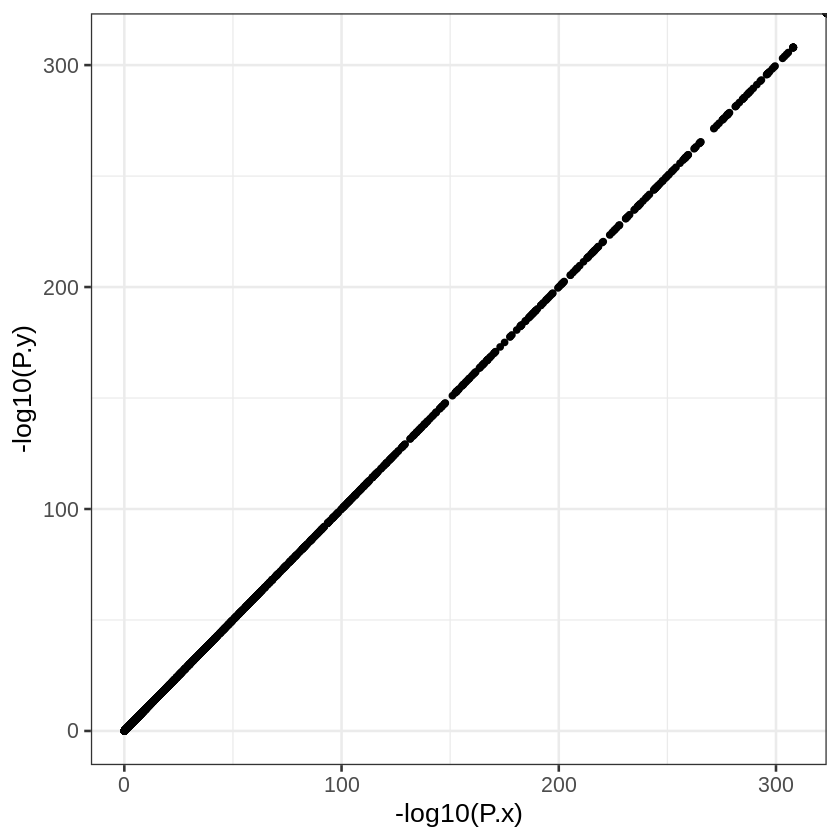

In [203]:
P_comparison_df %>% 
drop_na(P.x, P.y) %>%
ggplot(aes(x = -log10(P.x), y = -log10(P.y))) +
geom_point() +
theme_bw(base_size=16)


In [204]:
WBtestP_df %>% dim

[1] 1565    5